<a href="https://colab.research.google.com/github/JeffreyVerdiere1/Sound-Style-Recognition-with-ML-/blob/main/ML_Python_Final_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 'FMA small' dataset : top-genre classification on 8k 30s audio tracks

#### Loading libraries

In [ ]:
import os
import re
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### Loading 10s excerpt as numpy array for each track

In [ ]:
def load_data(dir_path, sampling_rate, duration):
    os.chdir(dir_path)
    
    dirlist = [f'{i:03d}' for i in range(156)] #list of folders
    offset = (30-duration)/2 #time to begin sampling
    
    data_dict = {}
    
    for prefix in tqdm(dirlist) :
        for track in os.listdir(prefix):
            try :
                audio = librosa.load(os.path.join(prefix, track), sr=sampling_rate, offset=offset, duration=duration)[0]
            except Exception:
                pass
            data_dict[int(re.search('(\d{6})\.mp3', track).groups()[0])] = audio #store track excerpt in dictionary with id keys
            
    return data_dict

In [ ]:
data_dict = load_data('D:/fma_small/fma_small', 44100, 5)

  0%|          | 0/156 [00:00<?, ?it/s]C:\Users\miche\AppData\Roaming\Python\Python39\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 1/156 [00:14<37:51, 14.66s/it]C:\Users\miche\AppData\Roaming\Python\Python39\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|██████████| 156/156 [29:10<00:00, 11.22s/it]


#### Saving/loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
joblib.dump(data_dict, '/content/drive/MyDrive/data_dict')

['D:/data_dict']

In [ ]:
data_dict = joblib.load('/content/drive/MyDrive/data_dict')

#### Making sure lengths are the same for all tracks

In [ ]:
def align_lengths(data_dict, sampling_rate, duration):
    length = sampling_rate*duration
    return {k:v for (k,v) in data_dict.items() if len(v)==length}

In [ ]:
data_dict = align_lengths(data_dict, 44100,5)

#### Building Metadata

In [ ]:
def build_metadata(metadata_path, data_dict):
    metadata = pd.read_csv(metadata_path, index_col = 'track_id')
    metadata = metadata[metadata['subset'] == 'small'] #select relevant metadata
    metadata = metadata[['title','name','genre_top','genres']]
    metadata = metadata[metadata.index.isin(list(data_dict.keys()))] #drop rows that have no audio match in the dataset
    return metadata

In [ ]:
metadata = build_metadata('/content/drive/MyDrive/tracks.csv', data_dict)

### Exploratory Metadata Analysis

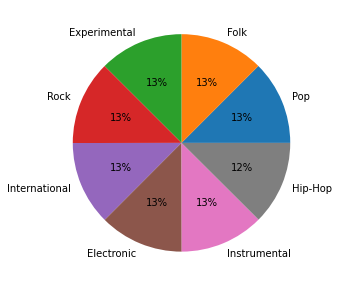

In [ ]:
metadata['genre_top'].value_counts().plot.pie(autopct='%1.0f%%', ylabel='', figsize=(5,5))

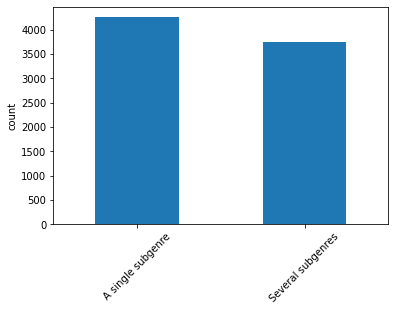

In [ ]:
metadata['genres'].str.contains(',').map({False:'A single subgenre',True:'Several subgenres'}).value_counts().plot.bar(ylabel='count',rot=45)

In [ ]:
genres = pd.read_csv('/content/drive/MyDrive/genres.csv', index_col='genre_id')

In [ ]:
counts = np.zeros((len(genres)))
for i in range(len(counts)):
  counts[i] = len(metadata[metadata['genres'].str.contains('(?<!\d){}(?!\d)'.format(str(list(genres.index)[i])))])
genres['counts'] = counts

In [ ]:
from treelib import Node, Tree
genre_tree = Tree()
genre_tree.create_node('Root', 0)
nodes = list(genres.index)
while nodes :
    for i in nodes :
        parent_id = genres.loc[i, 'parent']
        if genre_tree.contains(parent_id):
            genre_tree.create_node(genres.loc[i, 'title'] + ' : ' + str(int(genres.loc[i, 'counts'])), i, parent=parent_id)
            nodes.remove(i)
        else :
            pass
genre_tree.show()

Root
├── Blues : 0
│   └── Gospel : 0
├── Classical : 0
│   ├── 20th Century Classical : 0
│   ├── Chamber Music : 0
│   ├── Choral Music : 0
│   ├── Composed Music : 0
│   ├── Contemporary Classical : 0
│   ├── Opera : 0
│   └── Symphony : 0
├── Country : 0
│   ├── Americana : 0
│   ├── Bluegrass : 0
│   ├── Country & Western : 0
│   │   └── Western Swing : 0
│   └── Rockabilly : 0
├── Easy Listening : 0
│   ├── Easy Listening: Vocal : 0
│   ├── Lounge : 0
│   └── Nu-Jazz : 0
├── Electronic : 529
│   ├── Ambient Electronic : 157
│   ├── Breakcore - Hard : 3
│   ├── Chip Music : 161
│   │   └── Chiptune : 158
│   ├── Dance : 162
│   ├── Downtempo : 71
│   ├── Drum & Bass : 76
│   ├── Dubstep : 201
│   │   └── Skweee : 23
│   ├── Glitch : 41
│   ├── House : 161
│   │   └── Chill-out : 162
│   ├── IDM : 61
│   ├── Jungle : 28
│   ├── Minimal Electronic : 52
│   ├── Techno : 139
│   │   └── Bigbeat : 22
│   └── Trip-Hop : 81
├── Experimental : 585
│   ├── Audio Collage : 60
│   ├── Avant-

Text(0, 0.5, 'Number of different subgenre tags')

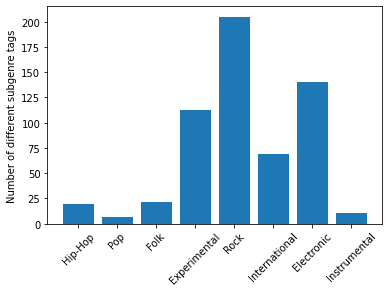

In [ ]:
value_by_genre = {}
for genre in metadata['genre_top'].unique() :
  sub_metadata = metadata[metadata['genre_top']==genre]
  value_by_genre[genre] = sub_metadata['genres'].nunique()
keys = value_by_genre.keys()
values = value_by_genre.values()
plt.bar(keys, values)
plt.xticks(rotation=45)
plt.ylabel('Number of different subgenre tags')

## First strategy (melspectrograms)

#### Computing mel spectrograms for all tracks

In [ ]:
def melspectrograms(data_dict, sampling_rate):
    dataset_lms = {}
    for key in tqdm(data_dict.keys()):
        S = librosa.feature.melspectrogram(data_dict[key], sr=sampling_rate)
        dataset_lms[key] = librosa.power_to_db(S, ref=np.max)

In [ ]:
dataset_lms = melspectrograms(data_dict, 44100)

 26%|██▌       | 2058/7997 [01:59<05:49, 16.98it/s]

#### Saving/loading the melspectrograms

In [ ]:
joblib.dump(dataset_lms,'/Users/jeffreyverdiere/Documents/ENSAE MS Data Science/ML avec Python/Projets/spectre')

['/Users/jeffreyverdiere/Documents/ENSAE MS Data Science/ML avec Python/Projets/spectre']

In [ ]:
dataset_lms = joblib.load('/Users/jeffreyverdiere/Documents/ENSAE MS Data Science/ML avec Python/Projets/spectre')

#### Displaying a few mel spectrograms for each genre

In [ ]:
def plot_melspectrograms(dataset_lms, metadata, n, sampling_rate):
    dummy_ids = {}
    for genre in metadata['genre_top'].unique() : #selecting n track_ids for each genre
        sub_df = metadata[metadata['genre_top'] == genre]
        dummy_ids[genre] = list(sub_df.index[0:n])
        
    fig = plt.figure(constrained_layout=True, figsize=(n*4,32)) #displaying spectrograms as a grid
    plt.rcParams.update({'font.size': 12})
    fig.suptitle('{} examples of mel-spectrograms for each genre'.format(n))
    subfigs = fig.subfigures(nrows=8, ncols=1)
    for num_row, subfig in enumerate(subfigs):
        genre = list(dummy_ids.keys())[num_row]
        subfig.suptitle(genre) #genre name
        axes = subfig.subplots(nrows=1, ncols=n)
        for col, ax in enumerate(axes):
            track_id = dummy_ids[genre][col]
            img = librosa.display.specshow(dataset_lms[track_id], sr=sampling_rate, x_axis='time', y_axis='mel', ax=ax) #spectrogram part
            ax.set_title(metadata.loc[track_id,'name']) #artist name for each track
        subfig.colorbar(img, format='%+2.f dB')

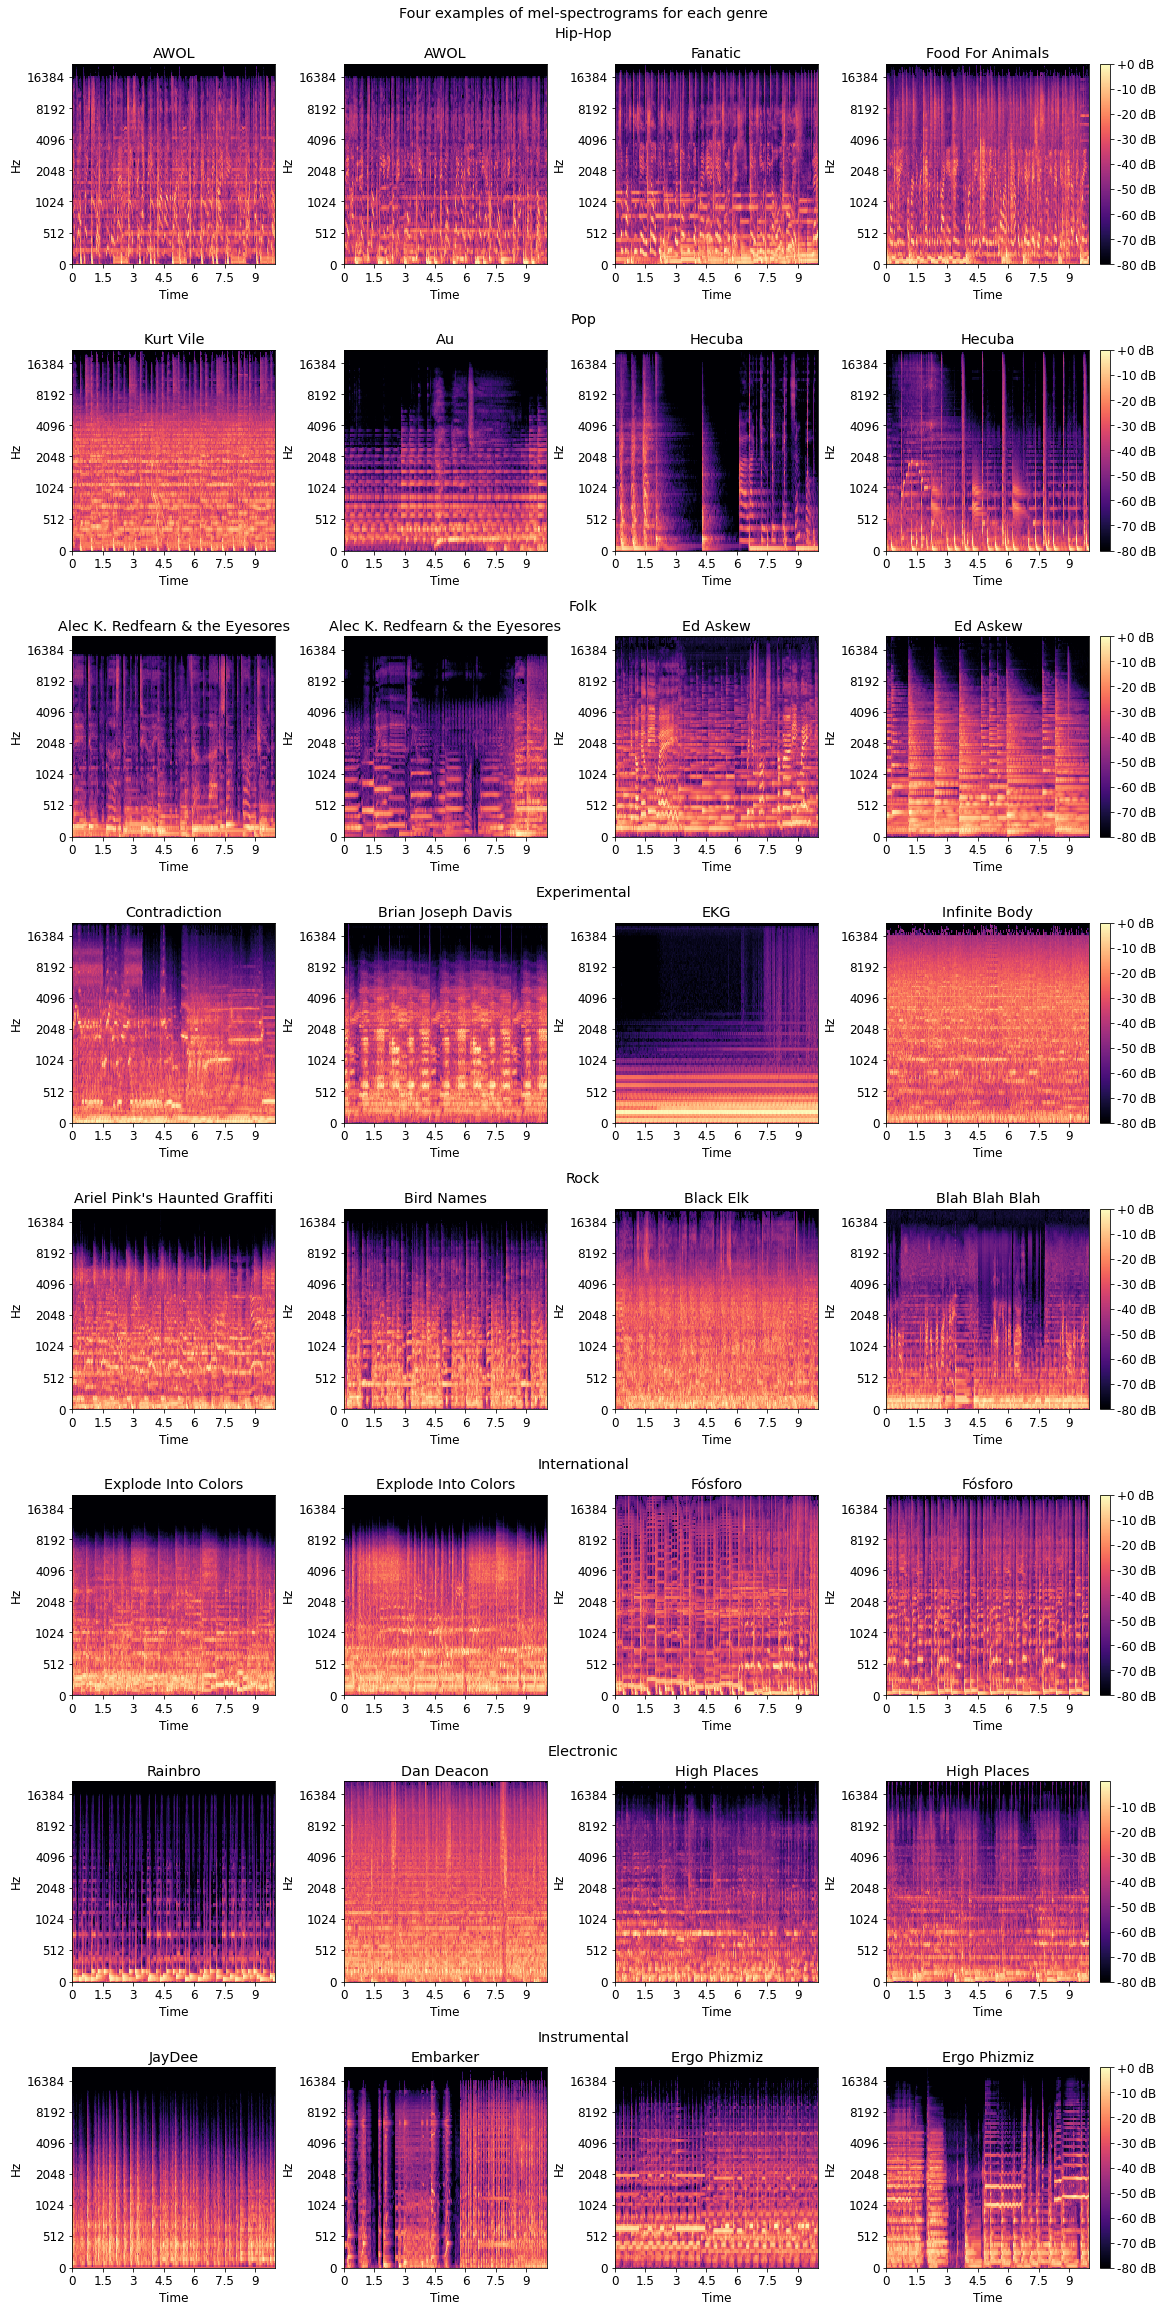

In [ ]:
plot_melspectrograms(dataset_lms, metadata, 4, 44100)

#### Building our final dataset

In [ ]:
def flat_split_sets(dataset_lms, metadata):
    flat_lms = {k:v.reshape((-1,)) for (k,v) in dataset_lms.items()} #reshaping arrays as 1d to perform scaling
    df = pd.DataFrame(flat_lms).T #track_id as index and flattened mel-spectrogram features as columns
    df['label'] = metadata['genre_top'] #adding target
    X_flat = df.drop('label', axis=1)
    y = df['label'] #numerically encoding the labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.25, stratify = y, random_state=0)
    return X_train_flat, X_test_flat, y_train, y_test

In [ ]:
X_train_flat, X_test_flat, y_train, y_test = flat_split_sets(dataset_lms, metadata)

In [ ]:
def scale_reshape(X_train_flat, X_test_flat,shape):
    scaler = FunctionTransformer(lambda x: x/80)
    X_train_flat = pd.DataFrame(scaler.transform(X_train_flat), index=X_train_flat.index, columns=X_train_flat.columns)
    X_test_flat = pd.DataFrame(scaler.transform(X_test_flat), index=X_test_flat.index, columns=X_test_flat.columns)
    
    #reshaping each spectrogram to feed a 2d-CNN
    n_train, n_test = len(X_train_flat), len(X_test_flat)

    X_train = np.zeros((n_train,shape[0],shape[1],1))
    for i in range(n_train):
        X_train[i] = X_train_flat.iloc[i,:].to_numpy().reshape(shape[0], shape[1], 1)

    X_test = np.zeros((n_test,shape[0],shape[1],1))
    for i in range(n_test):
        X_test[i] = X_test_flat.iloc[i,:].to_numpy().reshape(shape[0], shape[1], 1)
        
    return X_train, X_test

In [ ]:
X_train, X_test = scale_reshape(X_train_flat, X_test_flat, (dataset_lms[2].shape[0], dataset_lms[2].shape[1]))

#### Prebuilt ResNet

In [ ]:
base_resnet = keras.applications.ResNet50(weights=None, include_top=False, input_shape=(dataset_lms[2].shape[0], dataset_lms[2].shape[1], 1))
x = base_resnet.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
pred = keras.layers.Dense(8, activation='softmax')(x)
resnet = keras.Model(inputs = base_resnet.input, outputs = pred)

In [ ]:
resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [ ]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 108, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 114, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 54, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 54, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
resnet_history = resnet.fit(X_train, y_train, epochs=50, validation_data = (X_test, y_test), batch_size=16, shuffle=True)

Epoch 1/50
375/375 [==============================] - 760s 2s/step - loss: 2.3930 - accuracy: 0.2500 - val_loss: 1.7570 - val_accuracy: 0.3565
Epoch 2/50
375/375 [==============================] - 782s 2s/step - loss: 1.8697 - accuracy: 0.3612 - val_loss: 12.1335 - val_accuracy: 0.3770
Epoch 3/50
375/375 [==============================] - 736s 2s/step - loss: 1.7466 - accuracy: 0.4043 - val_loss: 2.5394 - val_accuracy: 0.3630
Epoch 4/50
375/375 [==============================] - 727s 2s/step - loss: 1.7111 - accuracy: 0.4153 - val_loss: 1.4914 - val_accuracy: 0.4850
Epoch 5/50
375/375 [==============================] - 722s 2s/step - loss: 1.6292 - accuracy: 0.4373 - val_loss: 2.9748 - val_accuracy: 0.4220
Epoch 6/50
375/375 [==============================] - 723s 2s/step - loss: 1.6923 - accuracy: 0.4310 - val_loss: 1.7121 - val_accuracy: 0.3670
Epoch 7/50
375/375 [==============================] - 728s 2s/step - loss: 1.7054 - accuracy: 0.4140 - val_loss: 1.9436 - val_accuracy: 0.349

## Second strategy
- MFCC
- Chroma STFT (chroma frequencies)
- Zero-crossing rate
- Spectral Rolloff
- Spectral Centroid

### Declaration of feature extraction functions

Computing MFCC Coefficients

In [ ]:
def mfccs(data_dict, sampling_rate, n_mfcc):
    dataset_mfccs = {}
    for key in tqdm(list(data_dict.keys())):
        dataset_mfccs[key] = librosa.feature.mfcc(data_dict[key], sr=sampling_rate, n_mfcc = n_mfcc)
    return dataset_mfccs

Computing Chroma STFT

In [ ]:
def chromas(data_dict, sampling_rate):
    dataset_chromas = {}
    for key in tqdm(list(data_dict.keys())):
        dataset_chromas[key] = librosa.feature.chroma_stft(data_dict[key], sr=sampling_rate)
    return dataset_chromas

Computing Spectral Centroids

In [ ]:
def centroid(data_dict, sampling_rate):
    dataset_centroid = {}
    for key in tqdm(list(data_dict.keys())):
        dataset_centroid[key] = librosa.feature.spectral_centroid(data_dict[key], sr=sampling_rate)
    return dataset_centroid

Computing Spectral Rolloff

In [ ]:
def rolloff(data_dict, sampling_rate):
    dataset_rolloff = {}
    for key in tqdm(list(data_dict.keys())):
        dataset_rolloff[key] = librosa.feature.spectral_rolloff(data_dict[key], sr=sampling_rate)
    return dataset_rolloff

Computing Zero-Crossing Rate

In [ ]:
def zcr(data_dict):
    dataset_zcr = {}
    for key in tqdm(list(data_dict.keys())):
        dataset_zcr[key] = librosa.feature.zero_crossing_rate(data_dict[key])
    return dataset_zcr

#### Computing moments and storing them in a dataframe

In [ ]:
def moment_to_frame(dataset, feature_name):
    main_list = []
    indexes = list(dataset.keys())
    n_rows = len(dataset)
    n_features = dataset[indexes[0]].shape[0]
    array = np.zeros((n_rows,2*n_features))
    
    for i in tqdm(range(n_rows)):
        for j in range(n_features):
            array[i,2*j] = np.mean(dataset[indexes[i]][j])
            array[i,2*j+1] = np.var(dataset[indexes[i]][j])
            
    columns = [['{}_{}_mean'.format(feature_name, i), '{}_{}_var'.format(feature_name, i)] for i in range(n_features)]
    columns = [a for sublist in columns for a in sublist]
            
    return pd.DataFrame(array, index=indexes, columns=columns)

### Building final dataset

In [ ]:
def feature_extraction(data_dict, sampling_rate, n_mfcc):
    dataset_mfccs = mfccs(data_dict, sampling_rate, n_mfcc)
    dataset_chromas = chromas(data_dict, sampling_rate)
    dataset_centroid = centroid(data_dict, sampling_rate)
    dataset_rolloff = rolloff(data_dict, sampling_rate)
    dataset_zcr = zcr(data_dict)
    df = moment_to_frame(dataset_mfccs, 'mfcc')
    dataset_dict = {'chroma':dataset_chromas,'centroid':dataset_centroid,'rolloff':dataset_rolloff,'zcr':dataset_zcr}
    for feature, dataset in dataset_dict.items():
        df = pd.concat([df, moment_to_frame(dataset, feature)], axis=1)
    return df

In [ ]:
final_df = feature_extraction(data_dict, 44100, 13)

  9%|▉         | 737/7997 [00:37<06:07, 19.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 7997/7997 [00:00<00:00, 30237.00it/s]


### Exploratory analysis of new features

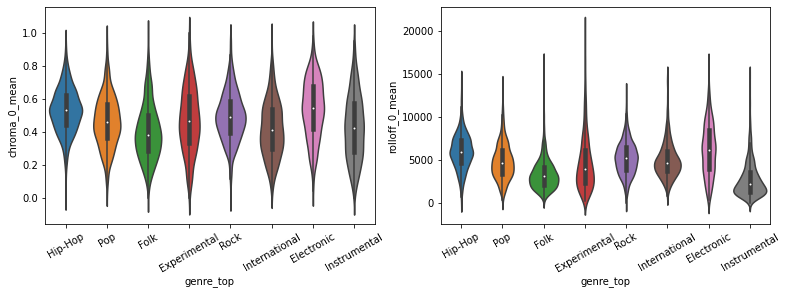

In [ ]:
features_to_explore = ['chroma_0_mean','rolloff_0_mean']
final_df_labels = pd.concat([final_df, metadata['genre_top']], axis=1)
final_df_labels
fig, axes = plt.subplots(nrows=1, ncols = len(features_to_explore), figsize=(13,4))
xlabels = [genre for genre in metadata['genre_top'].unique()]
for i in range(len(features_to_explore)):
  sns.violinplot(ax=axes[i], x="genre_top",y=features_to_explore[i], data=final_df_labels)
  axes[i].set_xticklabels(xlabels, rotation=30)

### Feature selection, set split and scaling

In [ ]:
def feature_selection(df,thres):
    corr_mat = df.corr()
    correlated_features = []
    features = corr_mat.columns
    for i in range(len(features)):
        if any(abs(corr_mat.iloc[i][i+1:]) > thres): #only values from the lower triangular part
             correlated_features.append(features[i])
    return df.drop(correlated_features, axis=1) 

In [ ]:
X = feature_selection(final_df,0.75)

In [ ]:
def split_scale(df, metadata):
    X = df
    y = metadata['genre_top']
    le = LabelEncoder()
    y = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=18)
    scaler = RobustScaler(unit_variance=True)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_scale(X, metadata)

### Training models

In [ ]:
models = [("knn", KNeighborsClassifier()), ("svc", LinearSVC(max_iter=10000)), ("rfc", RandomForestClassifier())]
grids = {"knn" : {'knn__n_neighbors':[9,17,27,39]},
        "svc" : {'svc__C': [0.5,1,2], 'svc__multi_class': ['ovr','crammer_singer']},
        "rfc" : {'rfc__max_depth': [10,20,50,100], 'rfc__max_features': [5,10,20], 'rfc__n_estimators': [100,200,500]}}
for name, model in models:
    pipe = Pipeline(steps=[(name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring='accuracy')
    clf.fit(X_train, y_train)
    print('Best parameters & results for {}'.format(name))
    print(clf.cv_results_['params'][clf.best_index_])
    print(clf.cv_results_['mean_test_score'][clf.best_index_])

Best parameters & results for knn
{'knn__n_neighbors': 17}
0.37892661464751615


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Best parameters & results for svc
{'svc__C': 2, 'svc__multi_class': 'ovr'}
0.4019075301106792
Best parameters & results for rfc
{'rfc__max_depth': 50, 'rfc__max_features': 10, 'rfc__n_estimators': 500}
0.44521071684805347


In [ ]:
y_pred = clf.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.45375

[Text(0, 0, 'rolloff_0_mean'),
 Text(0, 0, 'mfcc_0_mean'),
 Text(0, 0, 'mfcc_2_mean'),
 Text(0, 0, 'mfcc_0_var'),
 Text(0, 0, 'zcr_0_var'),
 Text(0, 0, 'zcr_0_mean'),
 Text(0, 0, 'rolloff_0_var'),
 Text(0, 0, 'mfcc_9_mean'),
 Text(0, 0, 'mfcc_6_var'),
 Text(0, 0, 'mfcc_12_var'),
 Text(0, 0, 'mfcc_11_mean'),
 Text(0, 0, 'mfcc_3_var'),
 Text(0, 0, 'mfcc_3_mean'),
 Text(0, 0, 'chroma_3_mean')]

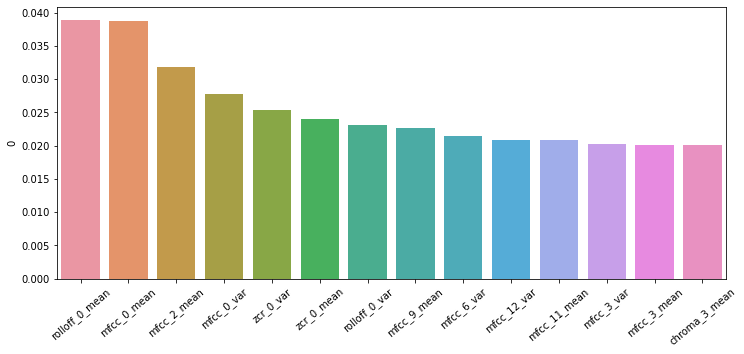

In [ ]:
feature_importance = pd.DataFrame(clf.best_estimator_.steps[0][1].feature_importances_, index=X.columns).sort_values(by=0, ascending=False)
feature_importance = feature_importance[feature_importance[0] > 0.02]
plt.figure(figsize=(12,5))
ax = sns.barplot(x=feature_importance.index, y=feature_importance[0])
ax.set_xticklabels(feature_importance.index, rotation=40)

Text(0, 0.5, 'Random Forest Accuracy')

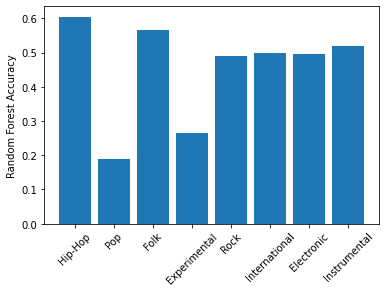

In [ ]:
accuracies = np.zeros(8)
le = LabelEncoder()
le.fit(metadata['genre_top'])
y_test_labels = pd.Series(le.inverse_transform(y_test), index=X_test.index)
y_test = pd.Series(y_test, index = X_test.index)
genre_list = metadata['genre_top'].unique()
for i in range(len(genre_list)):
  sub_y_test_labels = y_test_labels[y_test_labels == genre_list[i]]
  sub_y_test = y_test[y_test.index.isin(sub_y_test_labels.index)]
  sub_X_test = X_test[X_test.index.isin(sub_y_test.index)]
  sub_y_pred = clf.best_estimator_.predict(sub_X_test)
  accuracies[i] = accuracy_score(sub_y_test,sub_y_pred)
plt.bar(genre_list, accuracies)
plt.xticks(rotation=45)
plt.ylabel('Random Forest Accuracy')

#### Feed-forward neural network

In [ ]:
from tensorflow import keras
ffnn = keras.Sequential([
    keras.layers.Flatten(input_shape=(51,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='softmax'),
])

In [ ]:
ffnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [ ]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15,restore_best_weights=True)

In [ ]:
ffnn_history = ffnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=512, shuffle=True, callbacks=[stop])

Epoch 1/100
13/13 [==============================] - 1s 34ms/step - loss: 2.0460 - accuracy: 0.1893 - val_loss: 1.9239 - val_accuracy: 0.2481
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 1.8810 - accuracy: 0.2892 - val_loss: 1.7985 - val_accuracy: 0.3288
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 1.7615 - accuracy: 0.3344 - val_loss: 1.7126 - val_accuracy: 0.3669
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 1.6906 - accuracy: 0.3694 - val_loss: 1.6650 - val_accuracy: 0.3950
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 1.6564 - accuracy: 0.3891 - val_loss: 1.6332 - val_accuracy: 0.4025
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 1.6293 - accuracy: 0.4078 - val_loss: 1.6245 - val_accuracy: 0.4162
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 1.5991 - accuracy: 0.4119 - val_loss: 1.6151 - val_accuracy: 0.4200
Epoch 8/

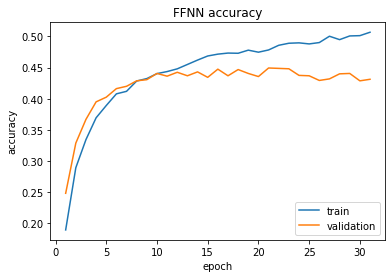

In [ ]:
n_epochs = ffnn_history.epoch[-1]+1
plt.plot(np.arange(1,n_epochs+1), ffnn_history.history['accuracy'])
plt.plot(np.arange(1,n_epochs+1), ffnn_history.history['val_accuracy'])
plt.title('FFNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

Text(0, 0.5, 'Feed-forward Neural Network Accuracy')

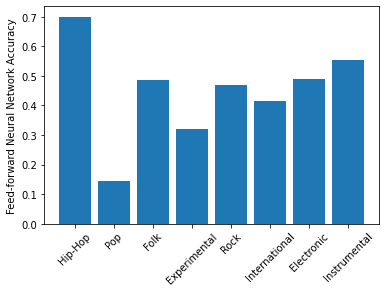

In [ ]:
accuracies = np.zeros(8)
le = LabelEncoder()
le.fit(metadata['genre_top'])
y_test_labels = pd.Series(le.inverse_transform(y_test), index=X_test.index)
y_test = pd.Series(y_test, index = X_test.index)
genre_list = metadata['genre_top'].unique()
for i in range(len(genre_list)):
  sub_y_test_labels = y_test_labels[y_test_labels == genre_list[i]]
  sub_y_test = y_test[y_test.index.isin(sub_y_test_labels.index)]
  sub_X_test = X_test[X_test.index.isin(sub_y_test.index)]
  sub_y_pred = np.argmax(ffnn.predict(sub_X_test), axis=1)
  accuracies[i] = accuracy_score(sub_y_test,sub_y_pred)
plt.bar(genre_list, accuracies)
plt.xticks(rotation=45)
plt.ylabel('Feed-forward Neural Network Accuracy')